# AI 스타일 영상 만들기
## Stable Diffusion + ControlNet + EbSynth
 - ref: 빵형의 개발도상국


## 1. 원본 영상 -> 프레임

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### 샘플 영상 다운로드

In [2]:
!mkdir /content/drive/MyDrive/ebsynth

!wget https://github.com/kairess/toy-datasets/raw/master/lynx.mp4 -O /content/drive/MyDrive/ebsynth/lynx.mp4

--2023-07-26 02:18:15--  https://github.com/kairess/toy-datasets/raw/master/lynx.mp4
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kairess/toy-datasets/master/lynx.mp4 [following]
--2023-07-26 02:18:15--  https://raw.githubusercontent.com/kairess/toy-datasets/master/lynx.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2650961 (2.5M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/ebsynth/lynx.mp4’

/content/drive/MyDr 100%[===================>]   2.53M  --.-KB/s    in 0.08s   

2023-07-26 02:18:15 (33.4 MB/s) - ‘/content/drive/MyDrive/ebsynth/lynx.mp4’ saved [2650961/2650961]

In [3]:
!mkdir /content/drive/MyDrive/ebsynth/frames

In [4]:
import cv2

cap = cv2.VideoCapture("/content/drive/MyDrive/ebsynth/lynx.mp4")

i = 0

while cap.isOpened():
    ret, img = cap.read()

    if not ret:
        break

    cv2.imwrite(f"/content/drive/MyDrive/ebsynth/frames/{str(i).zfill(5)}.png", img)

    i += 1

## 2. 스타일 변경 작업

Stable Diffusion + ControlNet

### ControlNet

In [5]:
!pip install -qq opencv-contrib-python diffusers transformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00


In [6]:
from glob import glob

frame_list = sorted(glob("/content/drive/MyDrive/ebsynth/frames/*.png"))

len(frame_list)

100

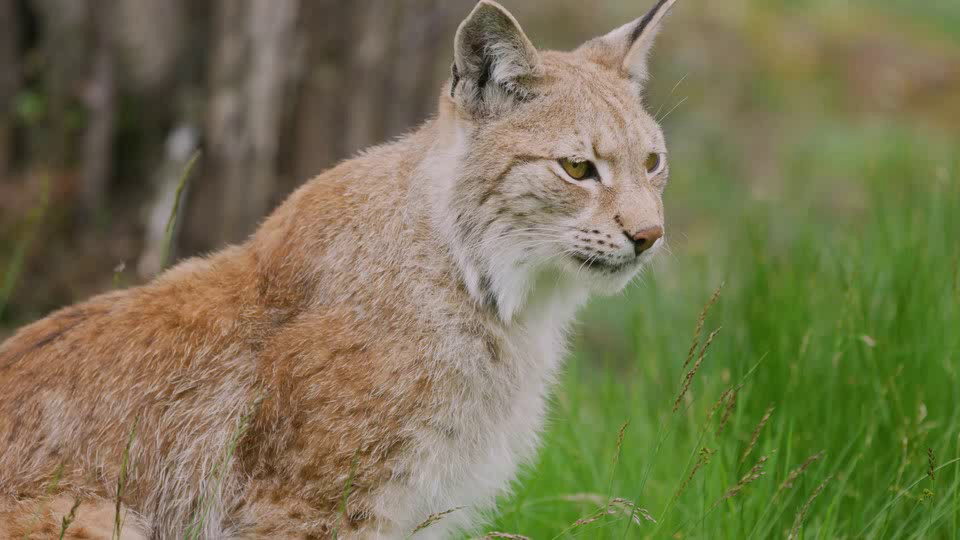

In [7]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image(frame_list[0])

image

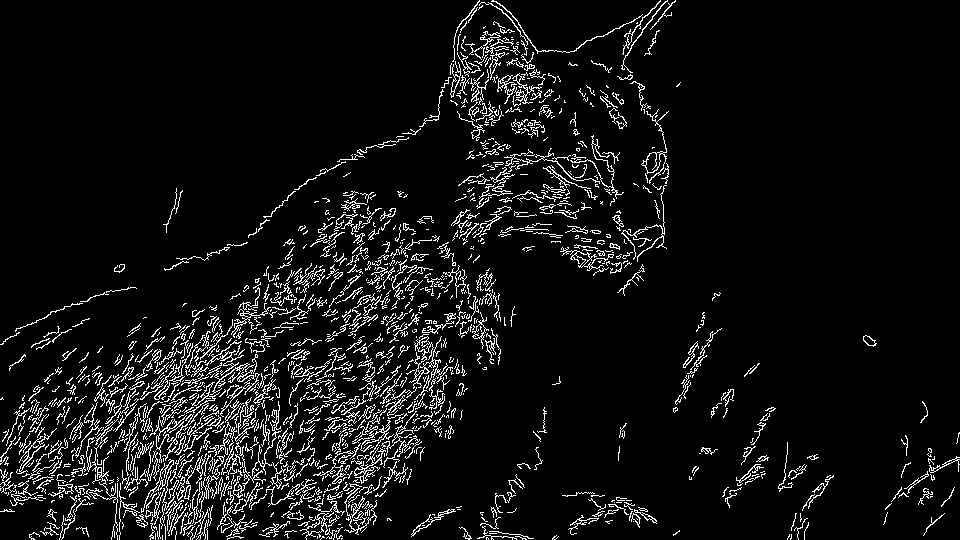

In [8]:
import cv2
from PIL import Image
import numpy as np

low_threshold = 100
high_threshold = 200

np_image = np.array(image)

canny_image = cv2.Canny(np_image, low_threshold, high_threshold)

canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

canny_image

In [9]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import UniPCMultistepScheduler
import torch

controlnet_model = "lllyasviel/sd-controlnet-canny"
sd_model = "stablediffusionapi/anything-v5"

controlnet = ControlNetModel.from_pretrained(
    controlnet_model,
    torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    sd_model, controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

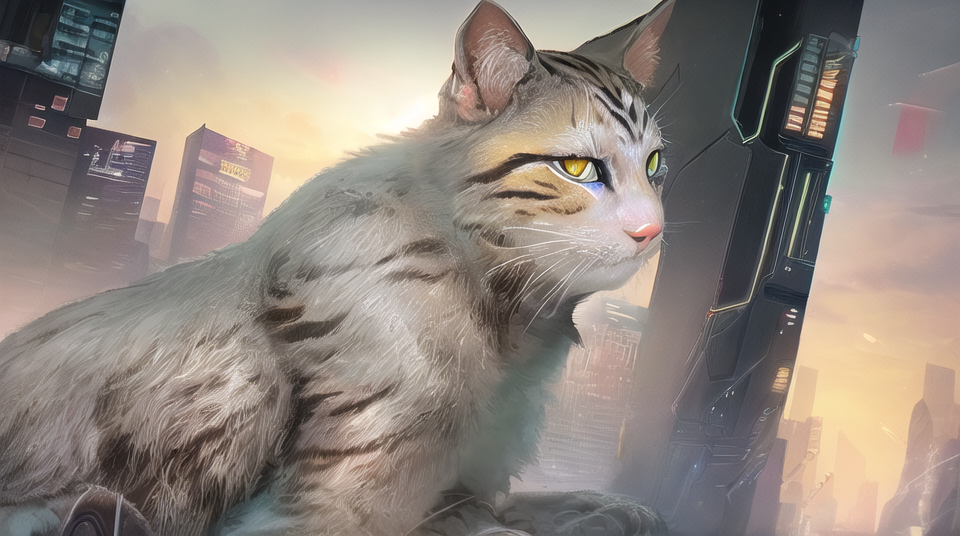

In [10]:
prompt = "masterpiece, best quality, cat, cyberpunk, city"
num_steps = 20
seed = 12345

out_image = pipe(
    prompt,
    num_inference_steps=num_steps,
    generator=torch.manual_seed(seed),
    image=canny_image
).images[0]

out_image

### 원본 이미지와 사이즈 일치시키기

In [11]:
print(image.size)
print(out_image.size)

(960, 540)
(960, 536)


In [12]:
out_image = out_image.resize(image.size)

print(out_image.size)

(960, 540)


In [13]:
!mkdir /content/drive/MyDrive/ebsynth/output

out_image.save("/content/drive/MyDrive/ebsynth/output/00000.png")

### 마지막 프레임 스타일 변경

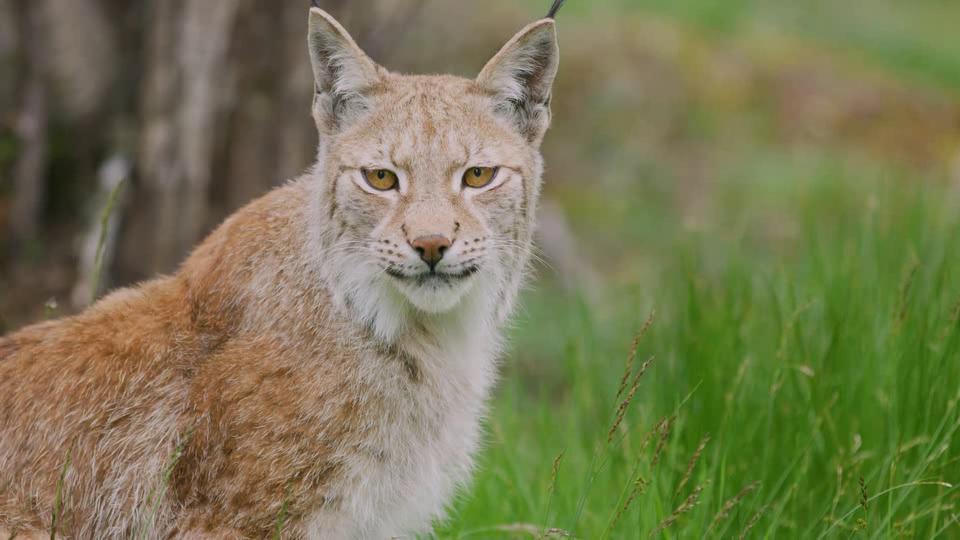

In [14]:
image = load_image(frame_list[-1])

image

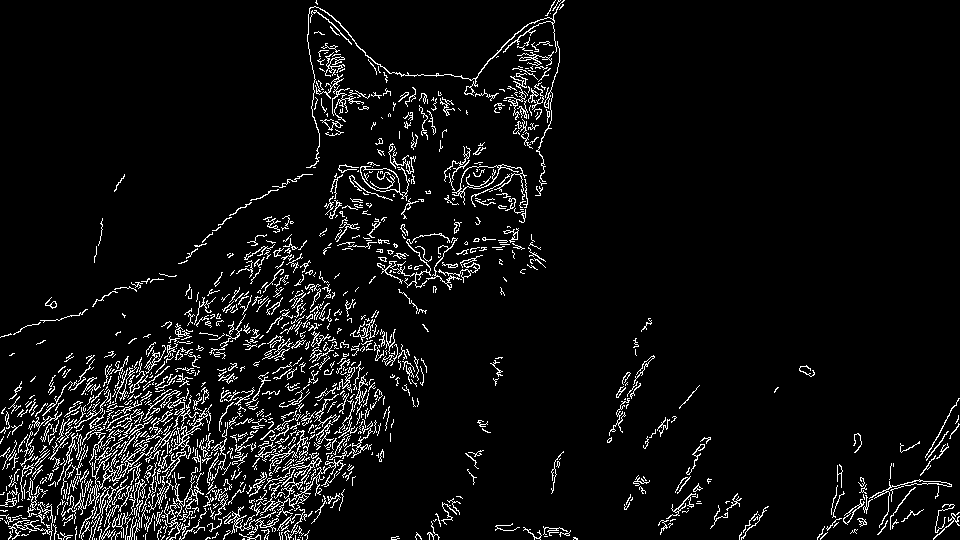

In [15]:
low_threshold = 100
high_threshold = 200

np_image = np.array(image)

canny_image = cv2.Canny(np_image, low_threshold, high_threshold)

canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

canny_image

  0%|          | 0/20 [00:00<?, ?it/s]

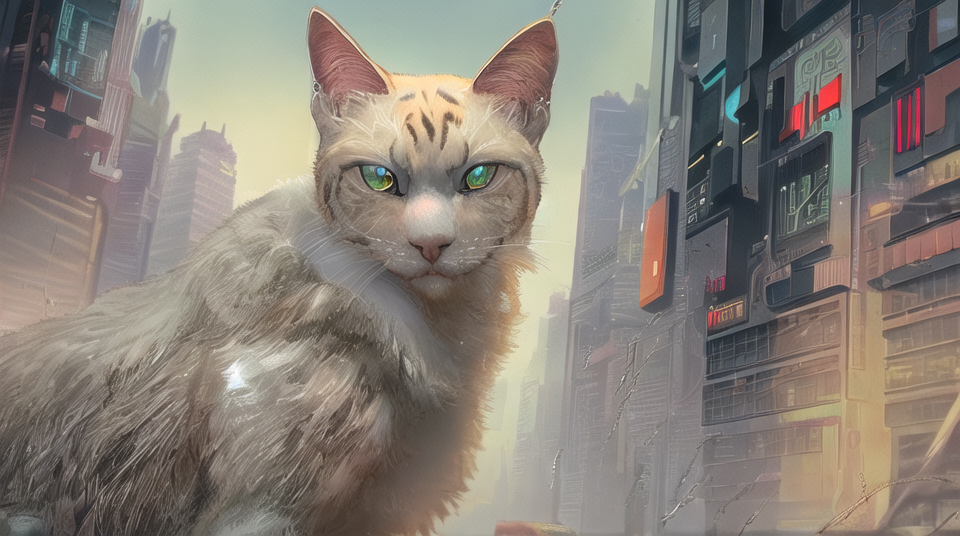

In [16]:
prompt = "masterpiece, best quality, cat, cyberpunk, city"
num_steps = 20
seed = 12345 # 시드를 일치시켜야 비슷한 스타일로 나옴

out_image = pipe(
    prompt,
    num_inference_steps=num_steps,
    generator=torch.manual_seed(seed),
    image=canny_image
).images[0]

out_image

In [17]:
out_image = out_image.resize(image.size)

out_image.save("/content/drive/MyDrive/ebsynth/output/00099.png")

### 모든 결과 다운로드

In [ ]:
!zip -r -q /content/drive/MyDrive/ebsynth/ebsynth.zip /content/drive/MyDrive/ebsynth/frames /content/drive/MyDrive/ebsynth/output

## 3. EbSynth

https://ebsynth.com

## 4. 결과 프레임 -> 영상

In [ ]:
!unzip -q /content/drive/MyDrive/ebsynth/out_00099.zip

In [ ]:
from glob import glob

img_list = sorted(glob("/content/out_00099/*.png"))

len(img_list)

100

In [ ]:
import cv2

img = cv2.imread(img_list[0])

H, W, _ = img.shape
FPS = 30

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter("/content/drive/MyDrive/ebsynth/result.mp4", fourcc, FPS, (W, H))

for img_path in img_list:
    img = cv2.imread(img_path)
    out.write(img)

out.release()